Define a spatial axis across multiple images that do not have the same number of annotations present.

The goal here is to have a consistent spatial axis scale across multiple samples, even if a sample (ie. an image) is missing certain annotations. 

In [1]:
from spatial_axis import spatial_axis
from spatial_axis.utility import (
    random_shapely_circles,
    create_broad_annotation_polygons,
)
from spatial_axis.spatial_axis import spatial_axis_to_labelmap
import matplotlib.pyplot as plt
from rasterio.features import rasterize
import geopandas
import numpy as np

In [2]:
IMG_SHAPE = (256, 256)
NUM_BROAD_ANNOTATION = 4

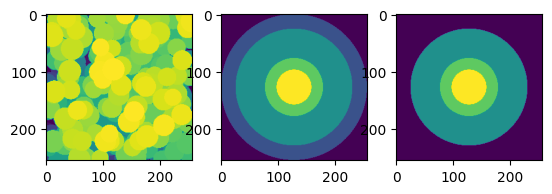

In [3]:
# Create some shapes and broad annotations

shapes = random_shapely_circles(
    image_shape=IMG_SHAPE,
    num_circles=500,
    min_radius=15,
    max_radius=20,
    seed=42,
)

labeled_shapes = [(polygon, idx + 1) for idx, polygon in enumerate(shapes)]
labeled_shapes = rasterize(
    [(poly, label) for poly, label in labeled_shapes],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

broad_annotations1 = create_broad_annotation_polygons(
    image_shape=IMG_SHAPE,
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION,
    downscale_factor=[0.8, 0.5, 0.6, 0.8],
)

broad_annotations2 = create_broad_annotation_polygons(
    image_shape=IMG_SHAPE,
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION - 1,
    downscale_factor=0.5,
)

labeled_broad_annotations1 = [
    (polygon, idx) for idx, polygon in enumerate(broad_annotations1)
]
labeled_broad_annotations1 = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations1],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)
# labeled_broad_annotations2 = [
#     (polygon, idx) for idx, polygon in enumerate(broad_annotations2)
# ]
# labeled_broad_annotations2 = rasterize(
#     [(poly, label) for poly, label in labeled_broad_annotations2],
#     out_shape=IMG_SHAPE,
#     fill=0,  # Background value
# )

## Edit labeled_broad_annotations1 and remove the outer ring
labeled_broad_annotations2 = np.where(labeled_broad_annotations1 == 1, 0, labeled_broad_annotations1)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(labeled_shapes)
ax[1].imshow(labeled_broad_annotations1)
ax[2].imshow(labeled_broad_annotations2)

In [4]:
# Convert shapes polygon list to a GeoDataFrame
shapes_df = geopandas.GeoDataFrame(geometry=shapes)

broad_df1 = geopandas.GeoDataFrame(
    {
        "geometry": broad_annotations1,
        "broad_annotation_id": np.arange(NUM_BROAD_ANNOTATION + 1),
    }
)
broad_df1 = broad_df1.set_index("broad_annotation_id")
broad_df2 = geopandas.GeoDataFrame(
    {
        "geometry": broad_annotations2,
        "broad_annotation_id": np.arange(NUM_BROAD_ANNOTATION),
    }
)
broad_df2 = broad_df2.set_index("broad_annotation_id")


# We'll use the same shapes for each spatial axis
shapes1 = shapes_df.copy()
shapes2 = shapes_df.copy()
shapes2

,geometry
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11..."
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168...."
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5..."
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735..."
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228...."
...,...
495,"POLYGON ((112.291 101.42, 112.203 99.609, 111...."
496,"POLYGON ((115.659 114.866, 115.581 113.279, 11..."
497,"POLYGON ((110.918 58.181, 110.844 56.675, 110...."
498,"POLYGON ((172.58 171.062, 172.493 169.289, 172..."


In [5]:
shapes1["spatial_axis"] = spatial_axis(
    shapes1, labeled_broad_annotations1, np.arange(1, NUM_BROAD_ANNOTATION + 1), k_neighbours=5, broad_annotations_to_exclude=[0]
)

shapes2["spatial_axis"] = spatial_axis(
    shapes2, labeled_broad_annotations2, np.arange(1, NUM_BROAD_ANNOTATION + 1), k_neighbours=5, broad_annotations_to_exclude=[0]
)

[(-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (0.0, 1.0, 0.0, 1.0),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5)]

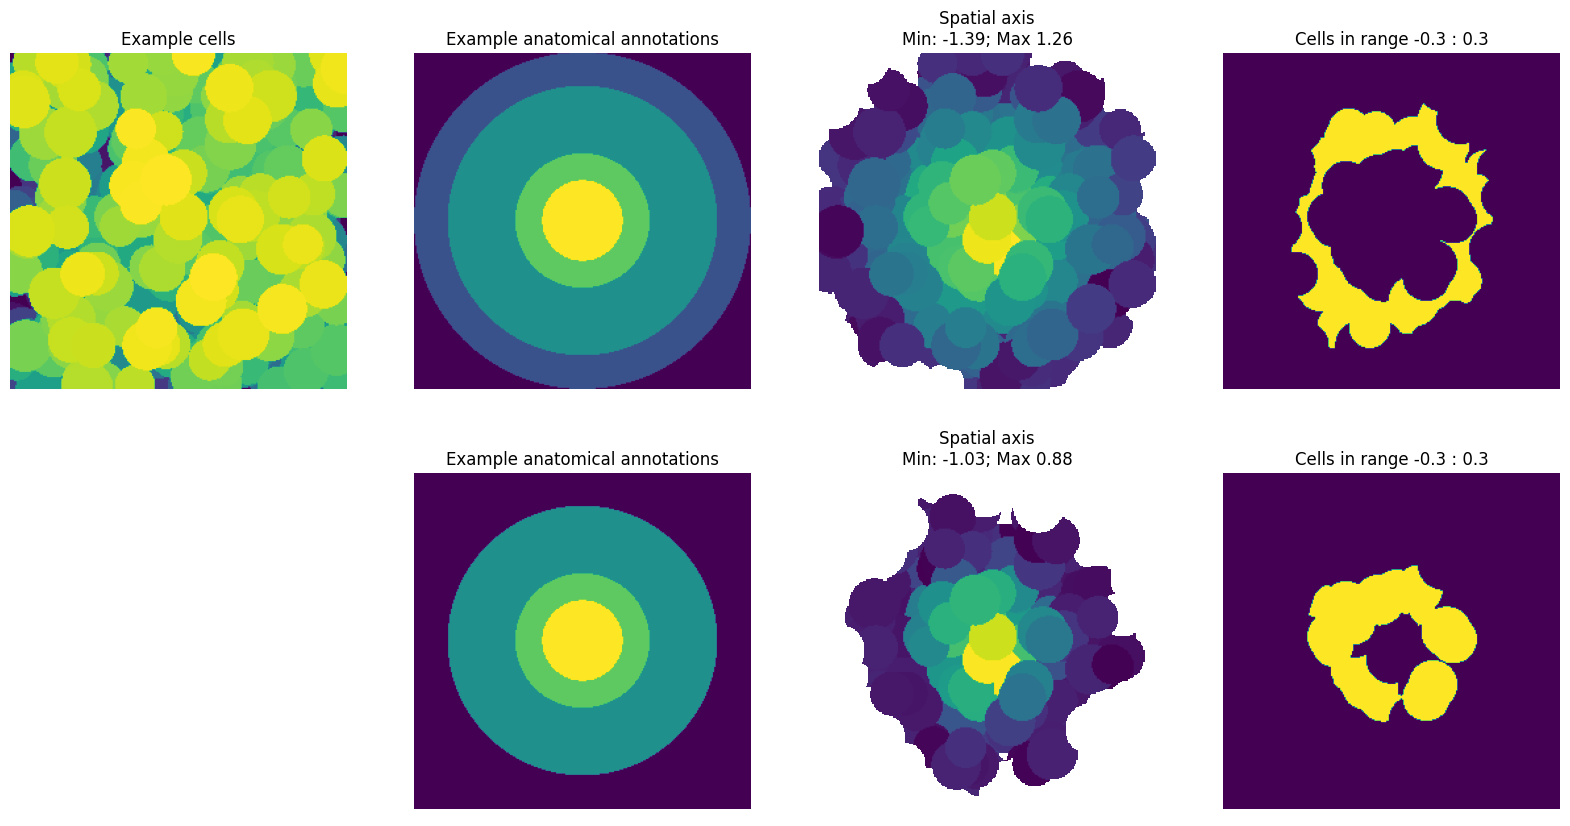

In [6]:
relative_array1 = spatial_axis_to_labelmap(shapes1, IMG_SHAPE, background_value=np.nan)
relative_array2 = spatial_axis_to_labelmap(shapes2, IMG_SHAPE, background_value=np.nan)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(relative_array1)
ax[0, 0].set_title("Example cells")
ax[0, 1].set_title("Example anatomical annotations")
ax[0, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array1).round(2)}; Max {np.nanmax(relative_array1).round(2)}")

ax[1, 1].imshow(labeled_broad_annotations2)
ax[1, 2].imshow(relative_array2)
ax[1, 1].set_title("Example anatomical annotations")
ax[1, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array2).round(2)}; Max {np.nanmax(relative_array2).round(2)}")

mi, ma = -0.3, 0.3
ax[0, 3].imshow(np.where(np.logical_and(relative_array1>=mi, relative_array1<=ma), 1, 0))
ax[1, 3].imshow(np.where(np.logical_and(relative_array2>=mi, relative_array2<=ma), 1, 0))
ax[0, 3].set_title(f"Cells in range {mi} : {ma}")
ax[1, 3].set_title(f"Cells in range {mi} : {ma}")

[_ax.axis("off") for _ax in ax.flatten()]

[(-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (0.0, 1.0, 0.0, 1.0),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5)]

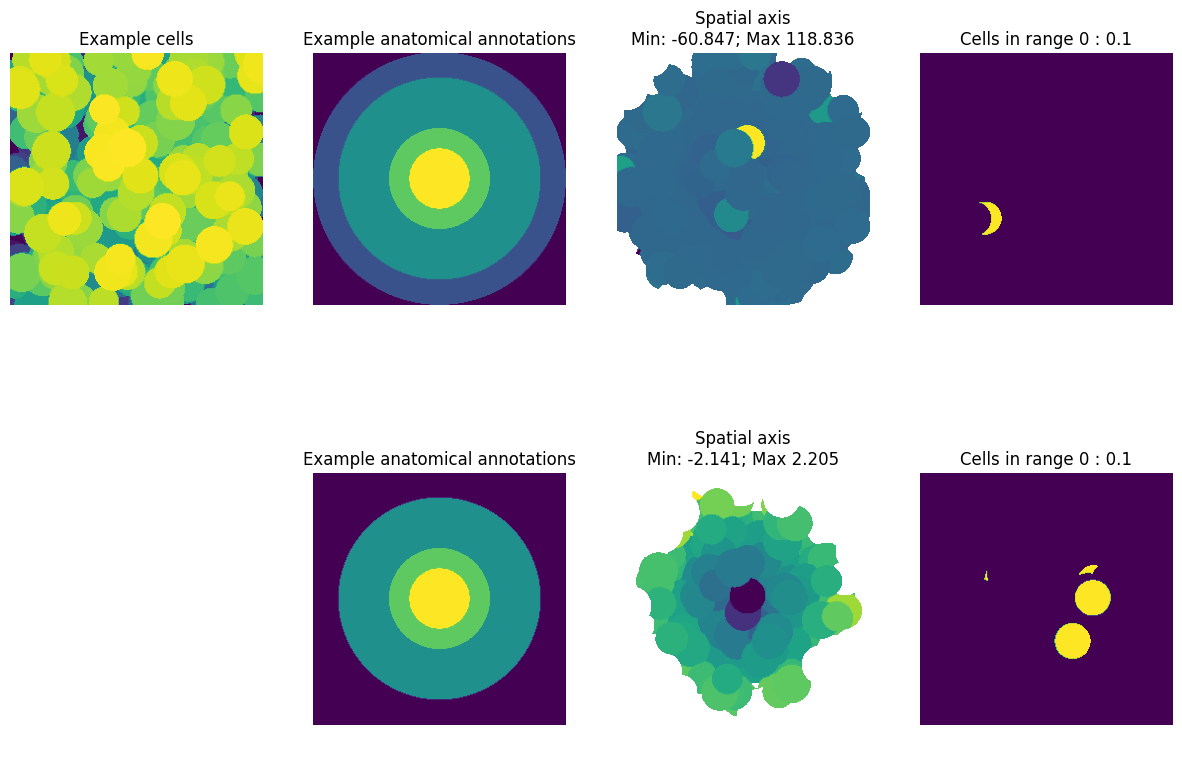

In [7]:
res = spatial_axis(
    [shapes1, shapes2], [labeled_broad_annotations1, labeled_broad_annotations2], np.arange(1, NUM_BROAD_ANNOTATION+1), k_neighbours=3, broad_annotations_to_exclude=[0]
)

shapes1["spatial_axis"] = res[:500]
shapes2["spatial_axis"] = res[500:]

relative_array1 = spatial_axis_to_labelmap(shapes1, IMG_SHAPE, background_value=np.nan)
relative_array2 = spatial_axis_to_labelmap(shapes2, IMG_SHAPE, background_value=np.nan)

fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(relative_array1)
ax[0, 0].set_title("Example cells")
ax[0, 1].set_title("Example anatomical annotations")
ax[0, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array1).round(3)}; Max {np.nanmax(relative_array1).round(3)}")

ax[1, 1].imshow(labeled_broad_annotations2)
ax[1, 2].imshow(relative_array2)
ax[1, 1].set_title("Example anatomical annotations")
ax[1, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array2).round(3)}; Max {np.nanmax(relative_array2).round(3)}")

mi, ma = 0, 0.1
ax[0, 3].imshow(np.where(np.logical_and(relative_array1>=mi, relative_array1<=ma), 1, 0))
ax[1, 3].imshow(np.where(np.logical_and(relative_array2>=mi, relative_array2<=ma), 1, 0))
ax[0, 3].set_title(f"Cells in range {mi} : {ma}")
ax[1, 3].set_title(f"Cells in range {mi} : {ma}")

[_ax.axis("off") for _ax in ax.flatten()]

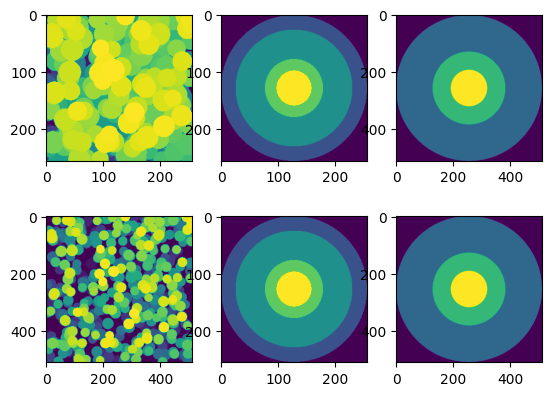

In [8]:
# Create some shapes and broad annotations

shapes1 = random_shapely_circles(
    image_shape=IMG_SHAPE,
    num_circles=500,
    min_radius=15,
    max_radius=20,
    seed=42,
)

shapes2 = random_shapely_circles(
    image_shape=(512, 512),
    num_circles=500,
    min_radius=15,
    max_radius=20,
    seed=42,
)

labeled_shapes = [(polygon, idx + 1) for idx, polygon in enumerate(shapes1)]
labeled_shapes = rasterize(
    [(poly, label) for poly, label in labeled_shapes],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

labeled_shapes2 = [(polygon, idx + 1) for idx, polygon in enumerate(shapes2)]
labeled_shapes2 = rasterize(
    [(poly, label) for poly, label in labeled_shapes2],
    out_shape=(512, 512),
    fill=0,  # Background value
)


broad_annotations1 = create_broad_annotation_polygons(
    image_shape=IMG_SHAPE,
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION,
    downscale_factor=[0.8, 0.5, 0.6, 0.8],
)

broad_annotations2 = create_broad_annotation_polygons(
    image_shape=(512, 512),
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION - 1,
    downscale_factor=0.5,
)

labeled_broad_annotations1 = [
    (polygon, idx) for idx, polygon in enumerate(broad_annotations1)
]
labeled_broad_annotations1 = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations1],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)
labeled_broad_annotations2 = [
    (polygon, idx) for idx, polygon in enumerate(broad_annotations2)
]
labeled_broad_annotations2 = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations2],
    out_shape=(512, 512),
    fill=0,  # Background value
)

fig, ax = plt.subplots(2, 3)
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(labeled_broad_annotations2)

ax[1, 0].imshow(labeled_shapes2)
ax[1, 1].imshow(labeled_broad_annotations1)
ax[1, 2].imshow(labeled_broad_annotations2)

1111 (1000,)
1111 (1000,)
1111 (1000,)


[(-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5)]

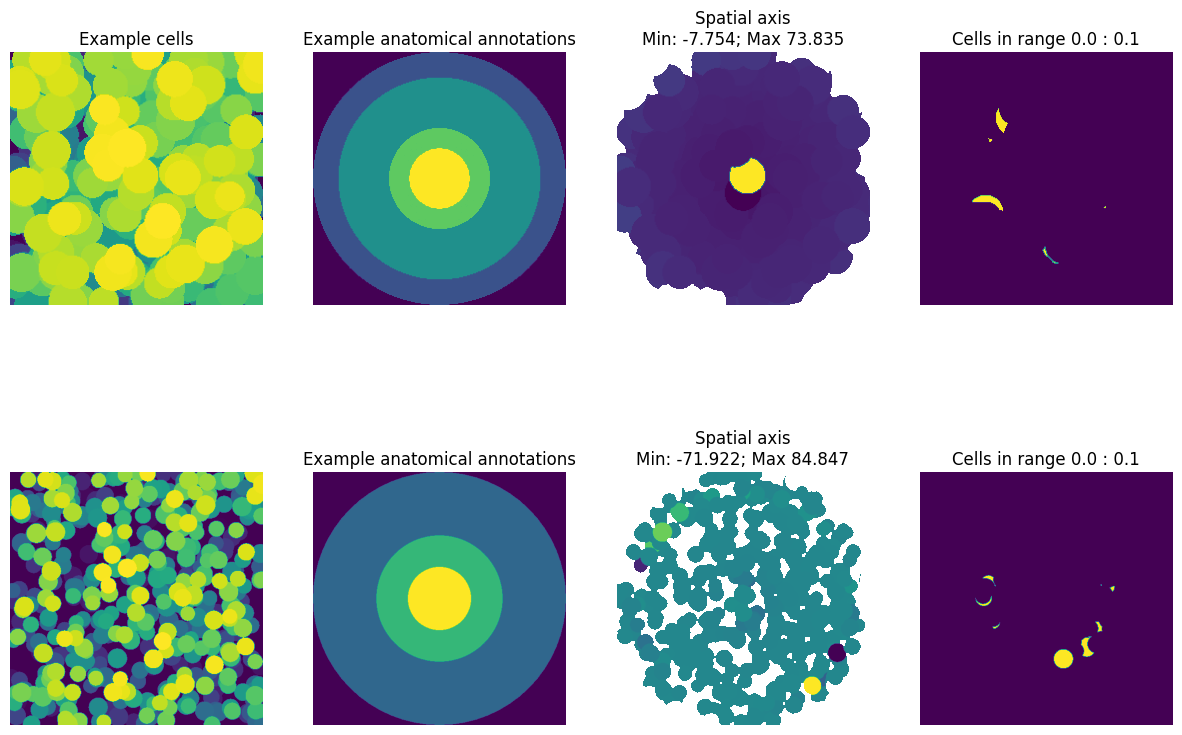

In [9]:
shapes1_df = geopandas.GeoDataFrame(geometry=shapes1)
shapes2_df = geopandas.GeoDataFrame(geometry=shapes2)

res = spatial_axis(
    [
        shapes1_df, 
        shapes2_df
    ], 
    [
        labeled_broad_annotations1, 
        labeled_broad_annotations2
    ], np.arange(1, NUM_BROAD_ANNOTATION+1), k_neighbours=5, broad_annotations_to_exclude=[0]
)


shapes1_df["spatial_axis"] = res[:500]
shapes2_df["spatial_axis"] = res[500:]

relative_array1 = spatial_axis_to_labelmap(shapes1_df, IMG_SHAPE, background_value=np.nan)
relative_array2 = spatial_axis_to_labelmap(shapes2_df, (512, 512), background_value=np.nan)

fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(relative_array1)
ax[0, 0].set_title("Example cells")
ax[0, 1].set_title("Example anatomical annotations")
ax[0, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array1).round(3)}; Max {np.nanmax(relative_array1).round(3)}")

ax[1, 0].imshow(labeled_shapes2)
ax[1, 1].imshow(labeled_broad_annotations2)
ax[1, 2].imshow(relative_array2)
ax[1, 1].set_title("Example anatomical annotations")
ax[1, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array2).round(3)}; Max {np.nanmax(relative_array2).round(3)}")

mi, ma = 0., 0.1
ax[0, 3].imshow(np.where(np.logical_and(relative_array1>=mi, relative_array1<=ma), 1, 0))
ax[1, 3].imshow(np.where(np.logical_and(relative_array2>=mi, relative_array2<=ma), 1, 0))
ax[0, 3].set_title(f"Cells in range {mi} : {ma}")
ax[1, 3].set_title(f"Cells in range {mi} : {ma}")

[_ax.axis("off") for _ax in ax.flatten()]

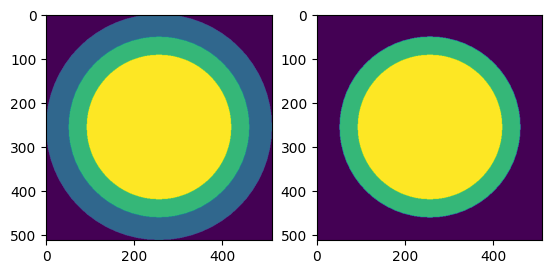

In [10]:
broad_annotations3 = create_broad_annotation_polygons(
    image_shape=(512, 512),
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION - 1,
    downscale_factor=0.8,
)

labeled_broad_annotations3 = [
    (polygon, idx) for idx, polygon in enumerate(broad_annotations3)
]
labeled_broad_annotations3 = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations3],
    out_shape=(512, 512),
    fill=0,  # Background value
)

b3 = np.where(labeled_broad_annotations3 == 1, 0, labeled_broad_annotations3)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(labeled_broad_annotations3)
ax[1].imshow(b3)

[(-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5),
 (-0.5, 511.5, 511.5, -0.5)]

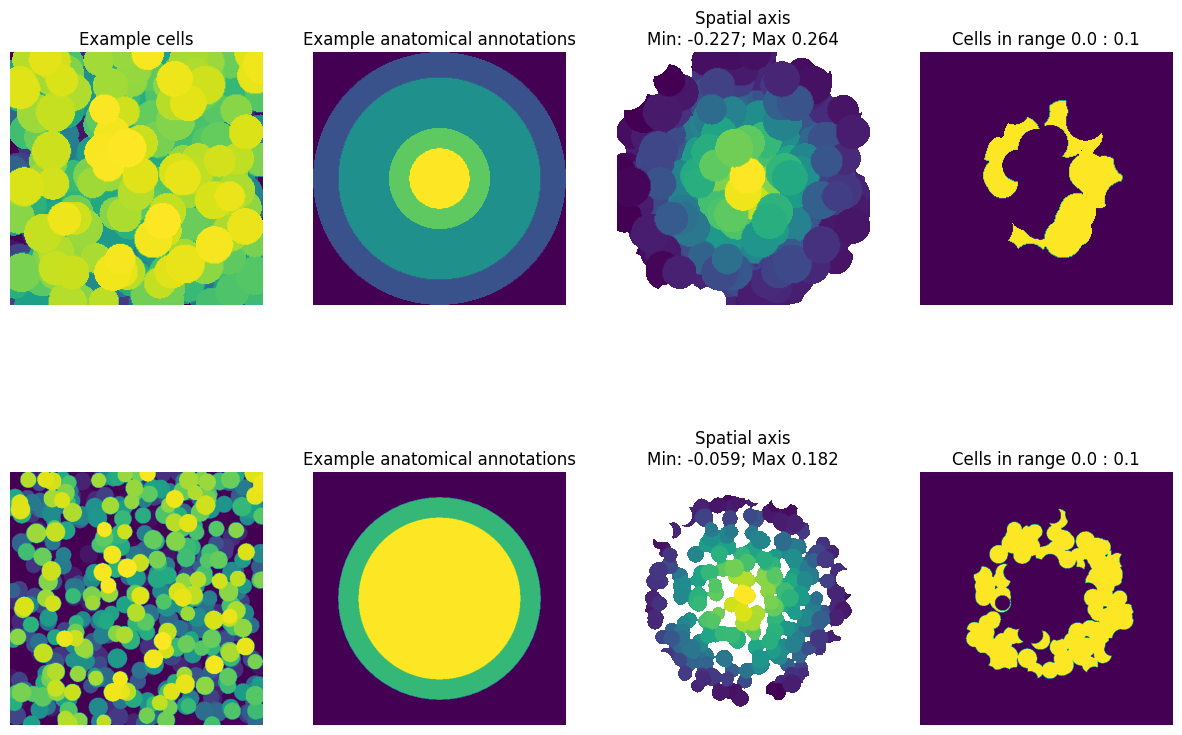

In [11]:
shapes1_df = geopandas.GeoDataFrame(geometry=shapes1)
shapes2_df = geopandas.GeoDataFrame(geometry=shapes2)

res = spatial_axis(
    [
        shapes1_df, 
        shapes2_df
    ], 
    [
        labeled_broad_annotations1, 
        b3
    ], np.arange(1, NUM_BROAD_ANNOTATION+1), k_neighbours=5, broad_annotations_to_exclude=[0]
)


shapes1_df["spatial_axis"] = res[:500]
shapes2_df["spatial_axis"] = res[500:]

relative_array1 = spatial_axis_to_labelmap(shapes1_df, IMG_SHAPE, background_value=np.nan)
relative_array2 = spatial_axis_to_labelmap(shapes2_df, (512, 512), background_value=np.nan)

fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(relative_array1)
ax[0, 0].set_title("Example cells")
ax[0, 1].set_title("Example anatomical annotations")
ax[0, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array1).round(3)}; Max {np.nanmax(relative_array1).round(3)}")

ax[1, 0].imshow(labeled_shapes2)
ax[1, 1].imshow(b3)
ax[1, 2].imshow(relative_array2)
ax[1, 1].set_title("Example anatomical annotations")
ax[1, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array2).round(3)}; Max {np.nanmax(relative_array2).round(3)}")

mi, ma = 0., 0.1
ax[0, 3].imshow(np.where(np.logical_and(relative_array1>=mi, relative_array1<=ma), 1, 0))
ax[1, 3].imshow(np.where(np.logical_and(relative_array2>=mi, relative_array2<=ma), 1, 0))
ax[0, 3].set_title(f"Cells in range {mi} : {ma}")
ax[1, 3].set_title(f"Cells in range {mi} : {ma}")

[_ax.axis("off") for _ax in ax.flatten()]

In [23]:
import numpy as np

# Example distance arrays (you can replace these with your actual distances)
D1 = np.array([5.1, 2.2, 7.3, 1.5, 3.6])
D2 = np.array([4.8, 2.1, 6.9])

# Example vector magnitudes (use your actual vector magnitudes)
magnitude = 10  # for simplicity, using a fixed magnitude

# 1. Normalize by the range of distances
def normalize_range(D):
    return (D - np.min(D)) / (np.max(D) - np.min(D))

D1_range = normalize_range(D1)
D2_range = normalize_range(D2)

# 2. Normalize by the maximum possible distance
def normalize_max_distance(D, magnitude):
    d_max = np.sqrt(2) * magnitude  # Max possible distance for normalized vectors
    return D / d_max

D1_max = normalize_max_distance(D1, magnitude)
D2_max = normalize_max_distance(D2, magnitude)

# 3. Normalize by the mean distance
def normalize_mean(D):
    mean = np.mean(D)
    return D / mean

D1_mean = normalize_mean(D1)
D2_mean = normalize_mean(D2)

# 4. Z-score normalization (standardization)
def z_score_normalize(D):
    mean = np.mean(D)
    std = np.std(D)
    return (D - mean) / std

D1_zscore = z_score_normalize(D1)
D2_zscore = z_score_normalize(D2)

# Print the results for each method
print("Normalized by range (D1):", D1_range)
print("Normalized by range (D2):", D2_range)

print("\nNormalized by max distance (D1):", D1_max)
print("Normalized by max distance (D2):", D2_max)

print("\nNormalized by mean (D1):", D1_mean)
print("Normalized by mean (D2):", D2_mean)

print("\nZ-score normalized (D1):", D1_zscore)
print("Z-score normalized (D2):", D2_zscore)


Normalized by range (D1): [0.62068966 0.12068966 1.         0.         0.36206897]
Normalized by range (D2): [0.5625 0.     1.    ]

Normalized by max distance (D1): [0.36062446 0.15556349 0.51618795 0.10606602 0.25455844]
Normalized by max distance (D2): [0.33941125 0.14849242 0.48790368]

Normalized by mean (D1): [1.29441624 0.55837563 1.85279188 0.38071066 0.91370558]
Normalized by mean (D2): [1.04347826 0.45652174 1.5       ]

Z-score normalized (D1): [ 0.55640772 -0.83461157  1.61166373 -1.17037485 -0.16308502]
Z-score normalized (D2): [ 0.10179732 -1.2724665   1.17066918]


```
Center the data on the origin:
P.x -= (maxX + minX) / 2
P.y -= (maxY + minY) / 2
Scale it down by the same amount in both dimensions, such that the larger of the two ranges becomes (-0.5, 0.5):
scale = max(maxX - minX, maxY - minY)
P.x /= scale
P.y /= scale
Translate the points by (0.5, 0.5) to bring everything where you want it:
P.x += 0.5
P.y += 0.5
```

In [53]:
def similar_scale(a1, a2):

    _a1, _a2 = a1.copy(), a2.copy()
    _a1 -= (max(_a1) + min(_a1)) / 2
    _a2 -= (max(_a2) + min(_a2)) / 2

    scale = max(max(_a1) - min(_a1), max(_a2) - min(_a2))

    _a1 /= scale
    _a2 /= scale

    _a1 += 0.5
    _a2 += 0.5

    return _a1, _a2

a1 = np.array([1, 2, 3, 4]).astype(float)
a2 = np.array([3, 3, 4, 4]).astype(float)

# Target scaling for a2
# [0.66, 0.66, 1, 1]

similar_scale(a1, a2), a1, a2


((array([0.        , 0.33333333, 0.66666667, 1.        ]),
  array([0.33333333, 0.33333333, 0.66666667, 0.66666667])),
 array([1., 2., 3., 4.]),
 array([3., 3., 4., 4.]))

In [55]:
np.interp(a1, (a1.min(), a1.max()), (-1, 1)), np.interp(a2, (a1.min(), a1.max()), (-1, 1))

(array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 array([0.33333333, 0.33333333, 1.        , 1.        ]))

In [14]:
(a1 - np.min(a1))/np.ptp(a1)

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [27]:
(a2 - np.min(a1))/np.ptp(a1)

array([0.33333333, 0.33333333, 0.66666667, 0.66666667])

In [30]:
actions = np.array([-1., 0.2, -0.3, 0.5])
mapped_low_high = np.array([[-0.4, 1.54],
                            [1.4, 1.54],
                            [-2.4, 2.],
                            [-1.54, 0.4]])


def remap(arr, mappings):
    out = arr.copy()
    a, b = mappings.T

    # remap out to [0,1]
    # assumes arr is [-1,1]
    out += 1.
    out /= 2.

    # remap out to [a,b]
    out *= b - a
    out += a
    return out


remap(actions, mapped_low_high)  # array([-0.4  ,  1.484, -0.86 , -0.085])

array([-0.4  ,  1.484, -0.86 , -0.085])

In [50]:
a1

array([1., 2., 3., 4.])

In [51]:
np.divide(a1, a1.max()), np.divide(a2, a1.max())

(array([0.25, 0.5 , 0.75, 1.  ]), array([0.75, 0.75, 1.  , 1.  ]))